In [1]:
import pandas as pd

# Obtener parejas y reportes

In [2]:
df_report_pairs = pd.read_pickle('data/raw_report_pairs.pkl')
df_reports = pd.read_pickle('data/raw_reports.pkl')

In [3]:
df_report_pairs.sample(3)

,type,id_M,id_D,statusM,statusD,componentM,componentD,summaryM,summaryD,commentsM,commentsD,text1M,text1D,text2M,text2D,text3M,text3D,text4M,text4D
649,duplicate,1781373,1733239,NEW,RESOLVED,Messaging System,Messaging System,Intermittent toolkit/components/messaging-syst...,Intermittent [tier 2] toolkit/components/messa...,,**Filed by:** mlaza [at] mozilla.com\n**Parsed...,Intermittent toolkit/components/messaging-syst...,Intermittent [tier 2] toolkit/components/messa...,Intermittent toolkit/components/messaging-syst...,Intermittent [tier 2] toolkit/components/messa...,Intermittent toolkit/components/messaging-syst...,Intermittent [tier 2] toolkit/components/messa...,Intermittent toolkit/components/messaging-syst...,Intermittent [tier 2] toolkit/components/messa...
2218,master,1758531,1735368,VERIFIED,RESOLVED,Address Bar,Downloads Panel,Apply best match logic to Merino suggestions,Fix browser_auto_close_window.js so it passes ...,Bug 1752604 implemented the best match MVP log...,This test is failing because it expects a dial...,Apply best match logic to Merino suggestions,Fix browser_auto_close_window.js so it passes ...,Apply best match logic to Merino suggestions A...,Fix browser_auto_close_window.js so it passes ...,Apply best match logic to Merino suggestions B...,Fix browser_auto_close_window.js so it passes ...,Apply best match logic to Merino suggestions A...,Fix browser_auto_close_window.js so it passes ...
2201,master,1636696,1360158,RESOLVED,NEW,Address Bar,Places,Highlight suggestions only if the typed token ...,Bookmarked favicons blinking on next bookmarks...,+++ This bug was initially created as a clone ...,STR:\n1. Open this URL - about:support\n2. Boo...,Highlight suggestions only if the typed token ...,Bookmarked favicons blinking on next bookmarks...,Highlight suggestions only if the typed token ...,Bookmarked favicons blinking on next bookmarks...,Highlight suggestions only if the typed token ...,Bookmarked favicons blinking on next bookmarks...,Highlight suggestions only if the typed token ...,Bookmarked favicons blinking on next bookmarks...


In [4]:
df_reports.sample(3)

,report_id,creation_time,status,component,dupe_of,summary,comments,text1,text2,text3,text4
711,1759395,2022-03-14 00:14:01,RESOLVED,Bookmarks & History,985024.0,duplicated 'manage bookmarks' button in 'boorm...,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,duplicated 'manage bookmarks' button in 'boorm...,duplicated 'manage bookmarks' button in 'boorm...,duplicated 'manage bookmarks' button in 'boorm...,duplicated 'manage bookmarks' button in 'boorm...
1267,1734784,2021-10-08 07:12:33,RESOLVED,about:logins,1733944.0,Twitter Sign in will no longer trigger the aut...,**Affected versions**\n- Firefox 94.0b3\n- Fir...,Twitter Sign in will no longer trigger the aut...,Twitter Sign in will no longer trigger the aut...,Twitter Sign in will no longer trigger the aut...,Twitter Sign in will no longer trigger the aut...
3326,1722276,2021-07-26 09:28:24,RESOLVED,General,NaN,Collect product page data,,Collect product page data,Collect product page data General,Collect product page data,Collect product page data General


# Preprocesamiento

## Caracteres extra

In [5]:
from string import punctuation
EXTRA_CHARACTERS = [p for p in punctuation if p not in list('_')]
ALLOWED_URL_CHARS = [':', '/', '?', '=', '&', '#']
URL_FORBIDDEN_CHARS = [c for c in EXTRA_CHARACTERS if c not in ALLOWED_URL_CHARS]

In [6]:
def process_token(token: str) -> list:
    if token.isdigit():
        return []

    token = token.lower()

    if token.startswith('http'):
        token = ''.join([w if w not in URL_FORBIDDEN_CHARS else '' for w in token])
    else:
        token = ''.join([w if w not in EXTRA_CHARACTERS else ' ' for w in token])

    token = token.strip()

    return token.split() if len(token.split()) > 1 else [token]

In [7]:
def remove_extra_characters(sentence: str) -> list:

    sentence_to_process = sentence.split() # Generar tokens por espacios
    sentence_processed = []

    # Eliminar tokens que sean solo números
    sentence_processed = [w for w in sentence_to_process if not w.isdigit()]
    # Eliminar tokens que sean solo puntuación
    sentence_processed = [w for w in sentence_processed if w not in list(punctuation)]

    result = []
    for w in sentence_processed:
        token = process_token(w)
        if len(token) > 1:
            for subtoken in token:
                result.extend(process_token(subtoken))
        else:
            result.extend(token)
    
    return result

## StopWords

In [8]:
from nltk.corpus import stopwords

CUSTOM_WORDS = ['info', 'https', 'http', 'org', 'com', 'net', 'edu']

def remove_stopwords(sentence: list) -> list:
    return [w for w in sentence if w not in stopwords.words('english') and w not in CUSTOM_WORDS]

## Lematización y stemming

In [9]:
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

LEMMATIZER = WordNetLemmatizer()
LEMMATIZER_PASS_TOKENS = ['js']

def lemmatize(sentence: list) -> list:
    return [LEMMATIZER.lemmatize(w) if w not in LEMMATIZER_PASS_TOKENS else w for w in sentence ]

[nltk_data] Downloading package omw-1.4 to /home/ajburri/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
from nltk.stem import SnowballStemmer
STEMMER = SnowballStemmer('english')
STEMMER_PASS_TOKENS = ['js']

def stem(sentence: list) -> list:
    return [STEMMER.stem(w) if w not in STEMMER_PASS_TOKENS else w for w in sentence]

# Aplicación y resultados

In [11]:
def preprocess_with_lemmatizer(sentence: str) -> str:
    # Pasar a minusculas
    p_sentence = sentence.lower()
    # Eliminar puntuación
    p_sentence = remove_extra_characters(p_sentence)
    # Eliminar palabras que no sean stopwords
    p_sentence = remove_stopwords(p_sentence)
    # Lematizar
    p_sentence = lemmatize(p_sentence)
    # Últimas modificaciones
    p_sentence = [t for t in p_sentence if t not in ['', ' ']]
    return p_sentence

In [12]:
def preprocess_with_stemmer(sentence: str) -> str:
    # Pasar a minusculas
    p_sentence = sentence.lower()
    # Eliminar puntuación
    p_sentence = remove_extra_characters(p_sentence)
    # Eliminar palabras que no sean stopwords
    p_sentence = remove_stopwords(p_sentence)
    # Lematizar
    p_sentence = stem(p_sentence)
    # Últimas modificaciones
    p_sentence = [t for t in p_sentence if t not in ['', ' ']]
    return p_sentence

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

## Conjunto total

In [14]:
df_reports['tokens1L'] = df_reports['text1'].apply(preprocess_with_lemmatizer)
df_reports['tokens2L'] = df_reports['text2'].apply(preprocess_with_lemmatizer)
df_reports['tokens3L'] = df_reports['text3'].apply(preprocess_with_lemmatizer)
df_reports['tokens4L'] = df_reports['text4'].apply(preprocess_with_lemmatizer)
df_reports['tokens1S'] = df_reports['text1'].apply(preprocess_with_stemmer)
df_reports['tokens2S'] = df_reports['text2'].apply(preprocess_with_stemmer)
df_reports['tokens3S'] = df_reports['text3'].apply(preprocess_with_stemmer)
df_reports['tokens4S'] = df_reports['text4'].apply(preprocess_with_stemmer)
df_reports.sample(3)

,report_id,creation_time,status,component,dupe_of,summary,comments,text1,text2,text3,text4,tokens1L,tokens2L,tokens3L,tokens4L,tokens1S,tokens2S,tokens3S,tokens4S
2809,1664053,2020-09-09 21:09:23,VERIFIED,Bookmarks & History,NaN,Show the Other Bookmarks folder in the bookmar...,To increase access to the bookmarks stored in ...,Show the Other Bookmarks folder in the bookmar...,Show the Other Bookmarks folder in the bookmar...,Show the Other Bookmarks folder in the bookmar...,Show the Other Bookmarks folder in the bookmar...,"[show, bookmark, folder, bookmark, bar, bookma...","[show, bookmark, folder, bookmark, bar, bookma...","[show, bookmark, folder, bookmark, bar, bookma...","[show, bookmark, folder, bookmark, bar, bookma...","[show, bookmark, folder, bookmark, bar, bookma...","[show, bookmark, folder, bookmark, bar, bookma...","[show, bookmark, folder, bookmark, bar, bookma...","[show, bookmark, folder, bookmark, bar, bookma..."
4633,1686766,2021-01-14 17:25:13,VERIFIED,Toolbars and Customization,NaN,Record a preference value when the user intera...,We want to record in the user profile whether ...,Record a preference value when the user intera...,Record a preference value when the user intera...,Record a preference value when the user intera...,Record a preference value when the user intera...,"[record, preference, value, user, interacts, l...","[record, preference, value, user, interacts, l...","[record, preference, value, user, interacts, l...","[record, preference, value, user, interacts, l...","[record, prefer, valu, user, interact, librari...","[record, prefer, valu, user, interact, librari...","[record, prefer, valu, user, interact, librari...","[record, prefer, valu, user, interact, librari..."
4063,1671715,2020-10-16 21:32:14,VERIFIED,Installer,NaN,Firefox requests 'Reboot Now' to complete inst...,"On a Windows 8.1 machine, installing Firefox 8...",Firefox requests 'Reboot Now' to complete inst...,Firefox requests 'Reboot Now' to complete inst...,Firefox requests 'Reboot Now' to complete inst...,Firefox requests 'Reboot Now' to complete inst...,"[firefox, request, reboot, complete, install, ...","[firefox, request, reboot, complete, install, ...","[firefox, request, reboot, complete, install, ...","[firefox, request, reboot, complete, install, ...","[firefox, request, reboot, complet, instal, sy...","[firefox, request, reboot, complet, instal, sy...","[firefox, request, reboot, complet, instal, sy...","[firefox, request, reboot, complet, instal, sy..."


In [15]:
unique_tokens1L = set(word for tokens in df_reports['tokens1L'] for word in tokens)
unique_tokens2L = set(word for tokens in df_reports['tokens2L'] for word in tokens)
unique_tokens3L = set(word for tokens in df_reports['tokens3L'] for word in tokens)
unique_tokens4L = set(word for tokens in df_reports['tokens4L'] for word in tokens)
unique_tokens1S = set(word for tokens in df_reports['tokens1S'] for word in tokens)
unique_tokens2S = set(word for tokens in df_reports['tokens2S'] for word in tokens)
unique_tokens3S = set(word for tokens in df_reports['tokens3S'] for word in tokens)
unique_tokens4S = set(word for tokens in df_reports['tokens4S'] for word in tokens)

print(f"Número de tokens únicos con lemmatizer en Conjunto 1: {len(unique_tokens1L)}")
print(f"Número de tokens únicos con lemmatizer en Conjunto 2: {len(unique_tokens2L)}")
print(f"Número de tokens únicos con lemmatizer en Conjunto 3: {len(unique_tokens3L)}")
print(f"Número de tokens únicos con lemmatizer en Conjunto 4: {len(unique_tokens4L)}")
print('-'*70)
print(f"Número de tokens únicos con stemmer en Conjunto 1: {len(unique_tokens1S)}")
print(f"Número de tokens únicos con stemmer en Conjunto 2: {len(unique_tokens2S)}")
print(f"Número de tokens únicos con stemmer en Conjunto 3: {len(unique_tokens3S)}")
print(f"Número de tokens únicos con stemmer en Conjunto 4: {len(unique_tokens4S)}")

Número de tokens únicos con lemmatizer en Conjunto 1: 5369
Número de tokens únicos con lemmatizer en Conjunto 2: 5397
Número de tokens únicos con lemmatizer en Conjunto 3: 12534
Número de tokens únicos con lemmatizer en Conjunto 4: 6443
----------------------------------------------------------------------
Número de tokens únicos con stemmer en Conjunto 1: 4427
Número de tokens únicos con stemmer en Conjunto 2: 4448
Número de tokens únicos con stemmer en Conjunto 3: 10403
Número de tokens únicos con stemmer en Conjunto 4: 5254


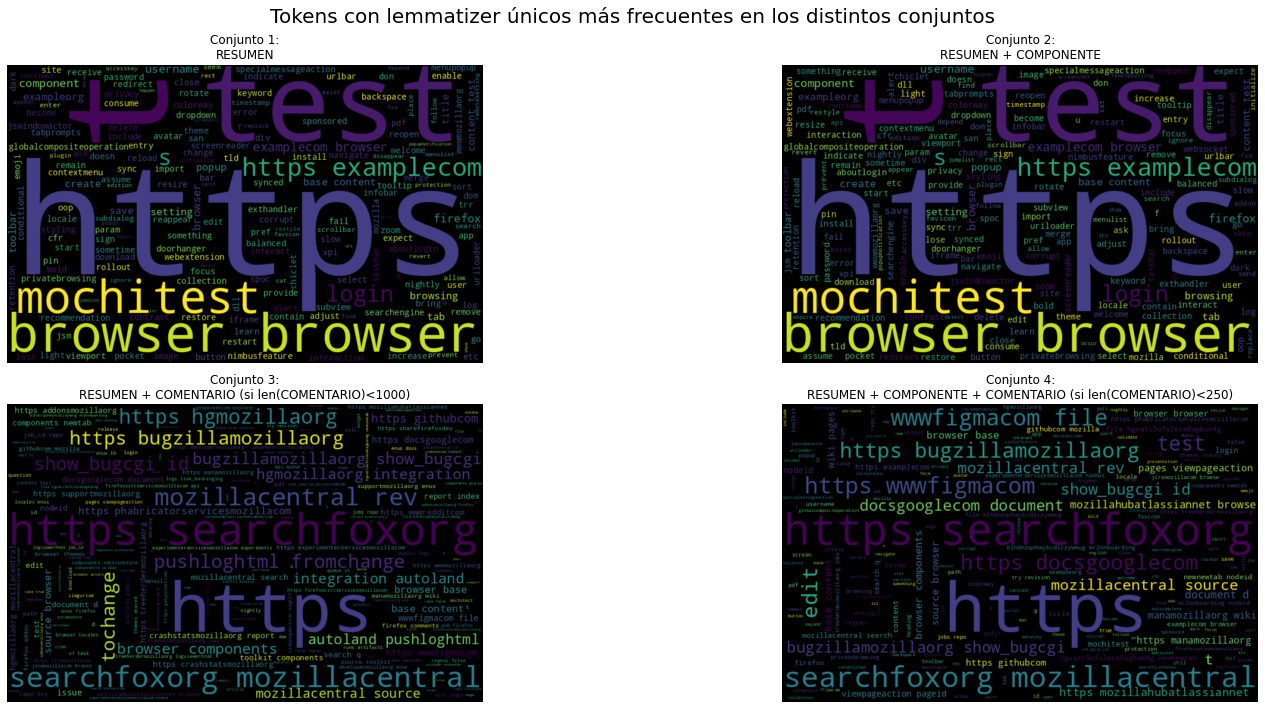

In [16]:
tokens1L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens1L))
tokens2L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens2L))
tokens3L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens3L))
tokens4L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens4L))

fig, axs = plt.subplots(2,2, figsize=(25,10))

axs[0,0].imshow(tokens1L_wordcloud, interpolation='bilinear')
axs[0,0].set_title('Conjunto 1:\nRESUMEN')
axs[0,0].axis('off')

axs[0,1].imshow(tokens2L_wordcloud, interpolation='bilinear')
axs[0,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0,1].axis('off')

axs[1,0].imshow(tokens3L_wordcloud, interpolation='bilinear')
axs[1,0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1,0].axis('off')

axs[1,1].imshow(tokens4L_wordcloud, interpolation='bilinear')
axs[1,1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1,1].axis('off')

fig.suptitle('Tokens con lemmatizer únicos más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()


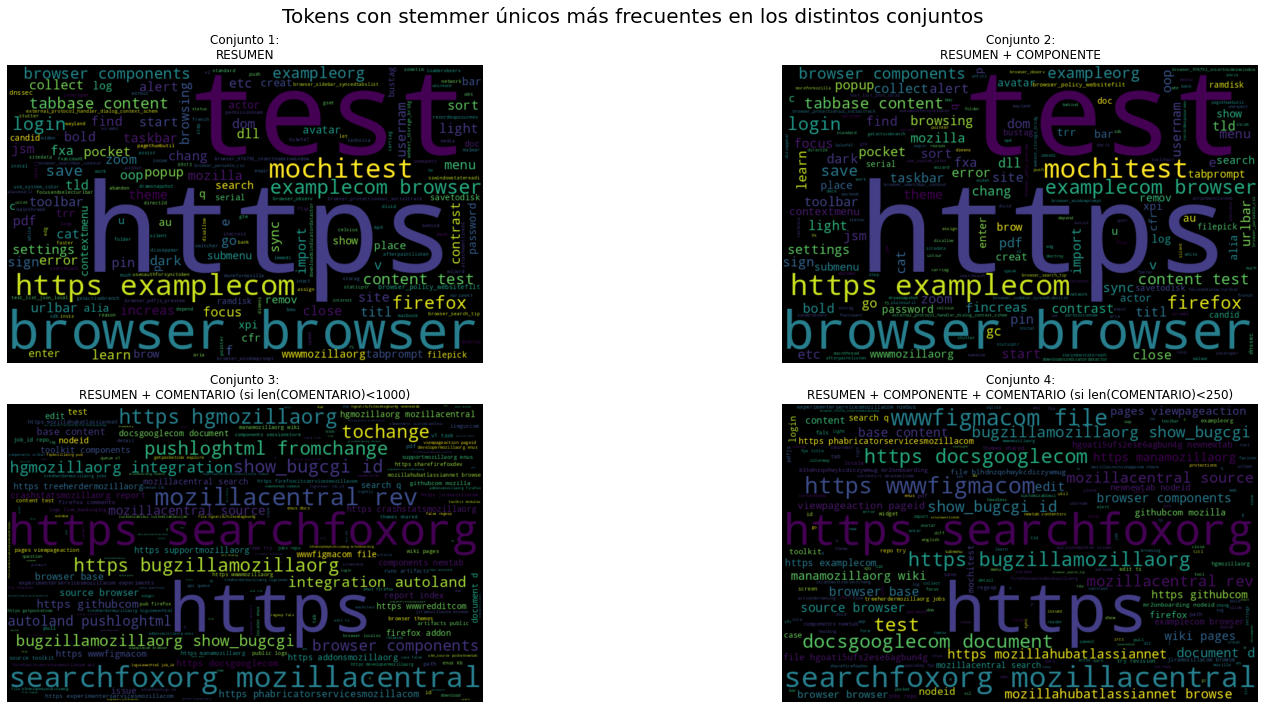

In [17]:
tokens1S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens1S))
tokens2S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens2S))
tokens3S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens3S))
tokens4S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens4S))

fig, axs = plt.subplots(2,2, figsize=(25,10))

axs[0,0].imshow(tokens1S_wordcloud, interpolation='bilinear')
axs[0,0].set_title('Conjunto 1:\nRESUMEN')
axs[0,0].axis('off')

axs[0,1].imshow(tokens2S_wordcloud, interpolation='bilinear')
axs[0,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0,1].axis('off')

axs[1,0].imshow(tokens3S_wordcloud, interpolation='bilinear')
axs[1,0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1,0].axis('off')

axs[1,1].imshow(tokens4S_wordcloud, interpolation='bilinear')
axs[1,1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1,1].axis('off')

fig.suptitle('Tokens con stemmer únicos más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()


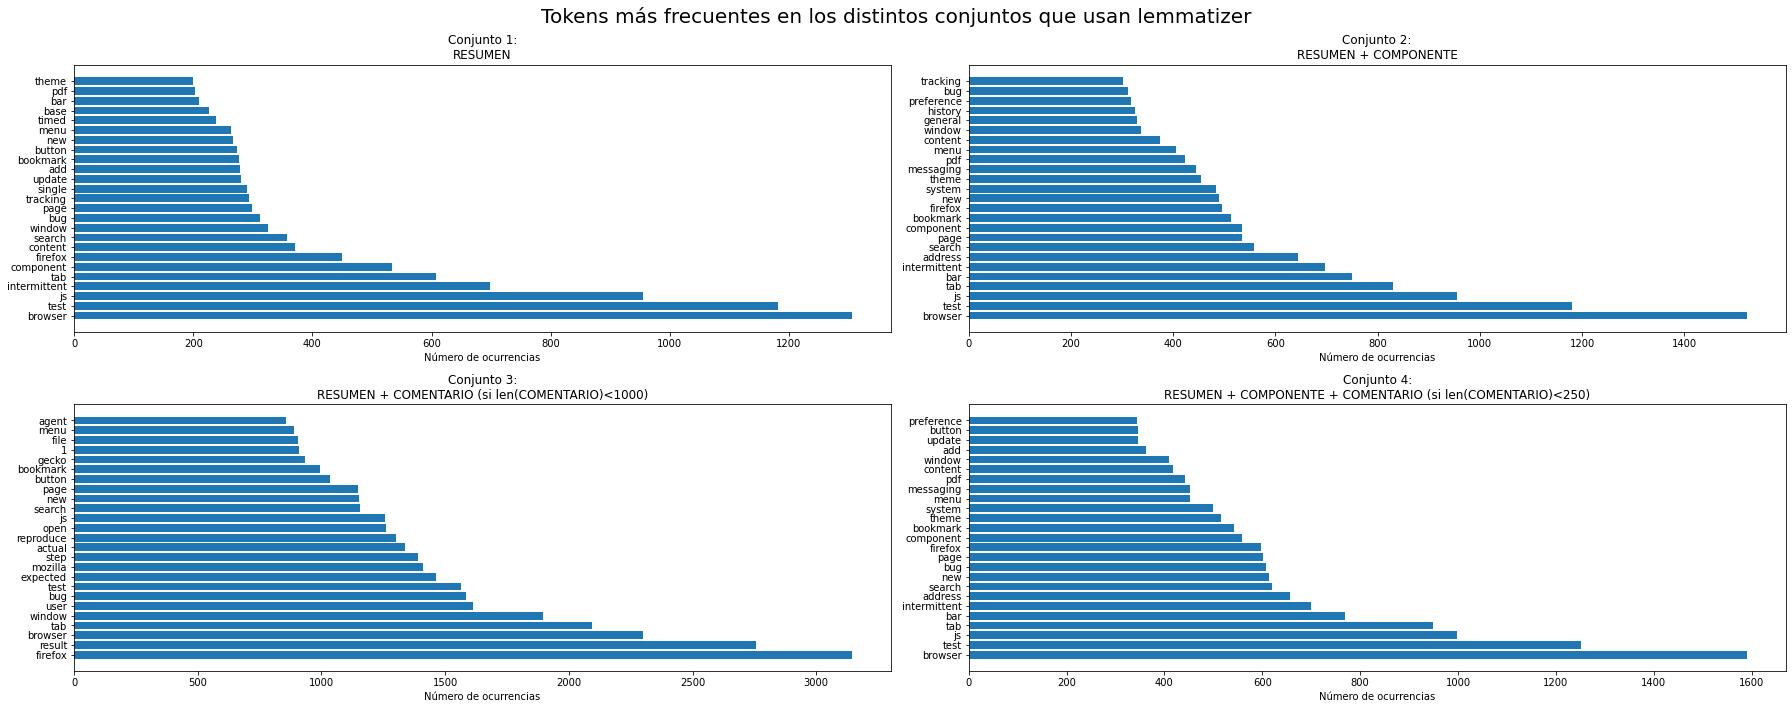

In [18]:
tokens1L_counter = Counter(word for tokens in df_reports['tokens1L'] for word in tokens)
tokens2L_counter = Counter(word for tokens in df_reports['tokens2L'] for word in tokens)
tokens3L_counter = Counter(word for tokens in df_reports['tokens3L'] for word in tokens)
tokens4L_counter = Counter(word for tokens in df_reports['tokens4L'] for word in tokens)

tokens1L_counter_25 = tokens1L_counter.most_common(25)
tokens2L_counter_25 = tokens2L_counter.most_common(25)
tokens3L_counter_25 = tokens3L_counter.most_common(25)
tokens4L_counter_25 = tokens4L_counter.most_common(25)

fig, axs = plt.subplots(2, 2, figsize=(25, 10))

axs[0, 0].barh(range(len(tokens1L_counter_25)), [count for word, count in tokens1L_counter_25], align='center')
axs[0, 0].set_yticks(range(len(tokens1L_counter_25)))
axs[0, 0].set_yticklabels([word for word, count in tokens1L_counter_25])
axs[0, 0].set_title('Conjunto 1:\nRESUMEN')
axs[0, 0].set_xlabel('Número de ocurrencias')

axs[0, 1].barh(range(len(tokens2L_counter_25)), [count for word, count in tokens2L_counter_25], align='center')
axs[0, 1].set_yticks(range(len(tokens2L_counter_25)))
axs[0, 1].set_yticklabels([word for word, count in tokens2L_counter_25])
axs[0, 1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0, 1].set_xlabel('Número de ocurrencias')

axs[1, 0].barh(range(len(tokens3L_counter_25)), [count for word, count in tokens3L_counter_25], align='center')
axs[1, 0].set_yticks(range(len(tokens3L_counter_25)))
axs[1, 0].set_yticklabels([word for word, count in tokens3L_counter_25])
axs[1, 0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1, 0].set_xlabel('Número de ocurrencias')

axs[1, 1].barh(range(len(tokens4L_counter_25)), [count for word, count in tokens4L_counter_25], align='center')
axs[1, 1].set_yticks(range(len(tokens4L_counter_25)))
axs[1, 1].set_yticklabels([word for word, count in tokens4L_counter_25])
axs[1, 1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1, 1].set_xlabel('Número de ocurrencias')

fig.suptitle('Tokens más frecuentes en los distintos conjuntos que usan lemmatizer', fontsize=20)
fig.tight_layout()
plt.show()

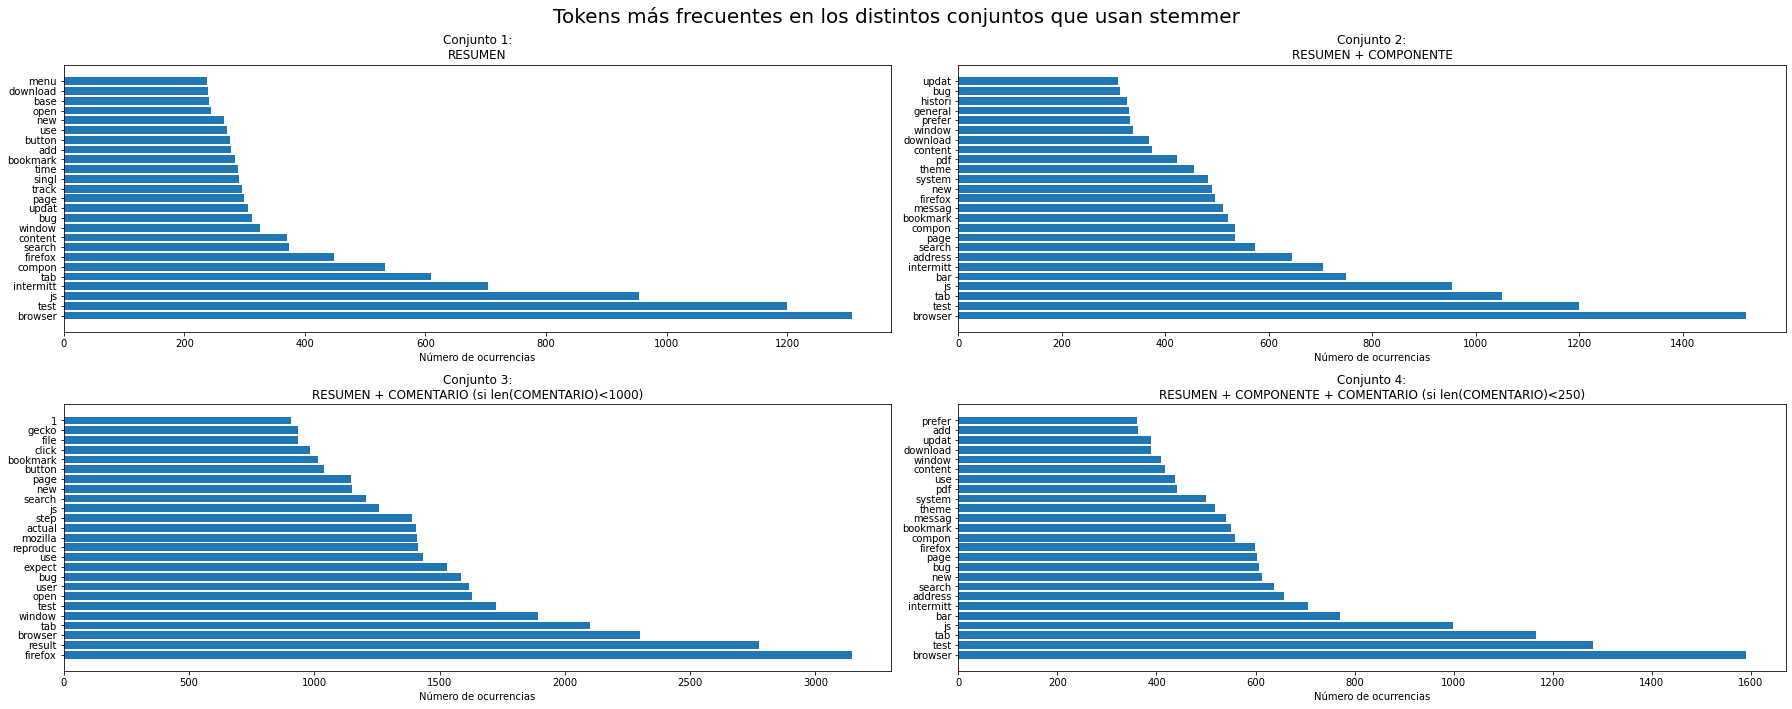

In [19]:
tokens1S_counter = Counter(word for tokens in df_reports['tokens1S'] for word in tokens)
tokens2S_counter = Counter(word for tokens in df_reports['tokens2S'] for word in tokens)
tokens3S_counter = Counter(word for tokens in df_reports['tokens3S'] for word in tokens)
tokens4S_counter = Counter(word for tokens in df_reports['tokens4S'] for word in tokens)

tokens1S_counter_25 = tokens1S_counter.most_common(25)
tokens2S_counter_25 = tokens2S_counter.most_common(25)
tokens3S_counter_25 = tokens3S_counter.most_common(25)
tokens4S_counter_25 = tokens4S_counter.most_common(25)

fig, axs = plt.subplots(2, 2, figsize=(25, 10))

axs[0, 0].barh(range(len(tokens1S_counter_25)), [count for word, count in tokens1S_counter_25], align='center')
axs[0, 0].set_yticks(range(len(tokens1S_counter_25)))
axs[0, 0].set_yticklabels([word for word, count in tokens1S_counter_25])
axs[0, 0].set_title('Conjunto 1:\nRESUMEN')
axs[0, 0].set_xlabel('Número de ocurrencias')

axs[0, 1].barh(range(len(tokens2S_counter_25)), [count for word, count in tokens2S_counter_25], align='center')
axs[0, 1].set_yticks(range(len(tokens2S_counter_25)))
axs[0, 1].set_yticklabels([word for word, count in tokens2S_counter_25])
axs[0, 1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0, 1].set_xlabel('Número de ocurrencias')

axs[1, 0].barh(range(len(tokens3S_counter_25)), [count for word, count in tokens3S_counter_25], align='center')
axs[1, 0].set_yticks(range(len(tokens3S_counter_25)))
axs[1, 0].set_yticklabels([word for word, count in tokens3S_counter_25])
axs[1, 0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1, 0].set_xlabel('Número de ocurrencias')

axs[1, 1].barh(range(len(tokens4S_counter_25)), [count for word, count in tokens4S_counter_25], align='center')
axs[1, 1].set_yticks(range(len(tokens4S_counter_25)))
axs[1, 1].set_yticklabels([word for word, count in tokens4S_counter_25])
axs[1, 1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1, 1].set_xlabel('Número de ocurrencias')

fig.suptitle('Tokens más frecuentes en los distintos conjuntos que usan stemmer', fontsize=20)
fig.tight_layout()
plt.show()

## Por parejas

In [20]:
df_duplicate_pairs = df_report_pairs[df_report_pairs.type == 'duplicate']

In [21]:
import warnings
warnings.filterwarnings('ignore')

df_duplicate_pairs['tokens1ML'] = df_duplicate_pairs['text1M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens1DL'] = df_duplicate_pairs['text1D'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens2ML'] = df_duplicate_pairs['text2M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens2DL'] = df_duplicate_pairs['text2D'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens3ML'] = df_duplicate_pairs['text3M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens3DL'] = df_duplicate_pairs['text3D'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens4ML'] = df_duplicate_pairs['text4M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens4DL'] = df_duplicate_pairs['text4D'].apply(preprocess_with_lemmatizer)

df_duplicate_pairs['unique_tokens1ML'] = df_duplicate_pairs['tokens1ML'].apply(set)
df_duplicate_pairs['unique_tokens1DL'] = df_duplicate_pairs['tokens1DL'].apply(set)
df_duplicate_pairs['unique_tokens2ML'] = df_duplicate_pairs['tokens2ML'].apply(set)
df_duplicate_pairs['unique_tokens2DL'] = df_duplicate_pairs['tokens2DL'].apply(set)
df_duplicate_pairs['unique_tokens3ML'] = df_duplicate_pairs['tokens3ML'].apply(set)
df_duplicate_pairs['unique_tokens3DL'] = df_duplicate_pairs['tokens3DL'].apply(set)
df_duplicate_pairs['unique_tokens4ML'] = df_duplicate_pairs['tokens4ML'].apply(set)
df_duplicate_pairs['unique_tokens4DL'] = df_duplicate_pairs['tokens4DL'].apply(set)

df_duplicate_pairs['unique_tokens_len1ML'] = df_duplicate_pairs['unique_tokens1ML'].apply(len)
df_duplicate_pairs['unique_tokens_len1DL'] = df_duplicate_pairs['unique_tokens1DL'].apply(len)
df_duplicate_pairs['unique_tokens_len2ML'] = df_duplicate_pairs['unique_tokens2ML'].apply(len)
df_duplicate_pairs['unique_tokens_len2DL'] = df_duplicate_pairs['unique_tokens2DL'].apply(len)
df_duplicate_pairs['unique_tokens_len3ML'] = df_duplicate_pairs['unique_tokens3ML'].apply(len)
df_duplicate_pairs['unique_tokens_len3DL'] = df_duplicate_pairs['unique_tokens3DL'].apply(len)
df_duplicate_pairs['unique_tokens_len4ML'] = df_duplicate_pairs['unique_tokens4ML'].apply(len)
df_duplicate_pairs['unique_tokens_len4DL'] = df_duplicate_pairs['unique_tokens4DL'].apply(len)

df_duplicate_pairs['common_tokens1L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens1ML'] & row['unique_tokens1DL'], axis=1)
df_duplicate_pairs['common_tokens2L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens2ML'] & row['unique_tokens2DL'], axis=1)
df_duplicate_pairs['common_tokens3L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens3ML'] & row['unique_tokens3DL'], axis=1)
df_duplicate_pairs['common_tokens4L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens4ML'] & row['unique_tokens4DL'], axis=1)

df_duplicate_pairs['common_tokens_len1L'] = df_duplicate_pairs['common_tokens1L'].apply(len)
df_duplicate_pairs['common_tokens_len2L'] = df_duplicate_pairs['common_tokens2L'].apply(len)
df_duplicate_pairs['common_tokens_len3L'] = df_duplicate_pairs['common_tokens3L'].apply(len)
df_duplicate_pairs['common_tokens_len4L'] = df_duplicate_pairs['common_tokens4L'].apply(len)

In [22]:
df_duplicate_pairs['tokens1MS'] = df_duplicate_pairs['text1M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens1DS'] = df_duplicate_pairs['text1D'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens2MS'] = df_duplicate_pairs['text2M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens2DS'] = df_duplicate_pairs['text2D'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens3MS'] = df_duplicate_pairs['text3M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens3DS'] = df_duplicate_pairs['text3D'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens4MS'] = df_duplicate_pairs['text4M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens4DS'] = df_duplicate_pairs['text4D'].apply(preprocess_with_stemmer)

df_duplicate_pairs['unique_tokens1MS'] = df_duplicate_pairs['tokens1MS'].apply(set)
df_duplicate_pairs['unique_tokens1DS'] = df_duplicate_pairs['tokens1DS'].apply(set)
df_duplicate_pairs['unique_tokens2MS'] = df_duplicate_pairs['tokens2MS'].apply(set)
df_duplicate_pairs['unique_tokens2DS'] = df_duplicate_pairs['tokens2DS'].apply(set)
df_duplicate_pairs['unique_tokens3MS'] = df_duplicate_pairs['tokens3MS'].apply(set)
df_duplicate_pairs['unique_tokens3DS'] = df_duplicate_pairs['tokens3DS'].apply(set)
df_duplicate_pairs['unique_tokens4MS'] = df_duplicate_pairs['tokens4MS'].apply(set)
df_duplicate_pairs['unique_tokens4DS'] = df_duplicate_pairs['tokens4DS'].apply(set)

df_duplicate_pairs['unique_tokens_len1MS'] = df_duplicate_pairs['unique_tokens1MS'].apply(len)
df_duplicate_pairs['unique_tokens_len1DS'] = df_duplicate_pairs['unique_tokens1DS'].apply(len)
df_duplicate_pairs['unique_tokens_len2MS'] = df_duplicate_pairs['unique_tokens2MS'].apply(len)
df_duplicate_pairs['unique_tokens_len2DS'] = df_duplicate_pairs['unique_tokens2DS'].apply(len)
df_duplicate_pairs['unique_tokens_len3MS'] = df_duplicate_pairs['unique_tokens3MS'].apply(len)
df_duplicate_pairs['unique_tokens_len3DS'] = df_duplicate_pairs['unique_tokens3DS'].apply(len)
df_duplicate_pairs['unique_tokens_len4MS'] = df_duplicate_pairs['unique_tokens4MS'].apply(len)
df_duplicate_pairs['unique_tokens_len4DS'] = df_duplicate_pairs['unique_tokens4DS'].apply(len)

df_duplicate_pairs['common_tokens1S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens1MS'] & row['unique_tokens1DS'], axis=1)
df_duplicate_pairs['common_tokens2S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens2MS'] & row['unique_tokens2DS'], axis=1)
df_duplicate_pairs['common_tokens3S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens3MS'] & row['unique_tokens3DS'], axis=1)
df_duplicate_pairs['common_tokens4S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens4MS'] & row['unique_tokens4DS'], axis=1)

df_duplicate_pairs['common_tokens_len1S'] = df_duplicate_pairs['common_tokens1S'].apply(len)
df_duplicate_pairs['common_tokens_len2S'] = df_duplicate_pairs['common_tokens2S'].apply(len)
df_duplicate_pairs['common_tokens_len3S'] = df_duplicate_pairs['common_tokens3S'].apply(len)
df_duplicate_pairs['common_tokens_len4S'] = df_duplicate_pairs['common_tokens4S'].apply(len)

In [23]:
df_duplicate_pairs[[
    'unique_tokens_len1ML','unique_tokens_len1DL','unique_tokens_len2ML','unique_tokens_len2DL',
    'unique_tokens_len3ML','unique_tokens_len3DL','unique_tokens_len4ML','unique_tokens_len4DL'
]].describe()

,unique_tokens_len1ML,unique_tokens_len1DL,unique_tokens_len2ML,unique_tokens_len2DL,unique_tokens_len3ML,unique_tokens_len3DL,unique_tokens_len4ML,unique_tokens_len4DL
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,8.695000,8.939000,10.040000,10.139000,26.809000,29.24100,11.050000,10.774000
std,3.302254,4.418235,3.362098,4.546686,18.702789,18.73045,4.439055,5.022763
min,2.000000,1.000000,3.000000,2.000000,2.000000,2.00000,3.000000,2.000000
25%,6.000000,6.000000,8.000000,7.000000,10.000000,12.00000,8.000000,7.000000
50%,9.000000,8.000000,10.000000,9.000000,20.500000,26.00000,11.000000,9.000000
75%,10.000000,11.000000,12.000000,12.000000,42.000000,44.00000,12.000000,13.000000
max,28.000000,26.000000,30.000000,29.000000,81.000000,81.00000,34.000000,32.000000


In [24]:
df_duplicate_pairs[[
    'unique_tokens_len1MS','unique_tokens_len1DS','unique_tokens_len2MS','unique_tokens_len2DS',
    'unique_tokens_len3MS','unique_tokens_len3DS','unique_tokens_len4MS','unique_tokens_len4DS'
]].describe()

,unique_tokens_len1MS,unique_tokens_len1DS,unique_tokens_len2MS,unique_tokens_len2DS,unique_tokens_len3MS,unique_tokens_len3DS,unique_tokens_len4MS,unique_tokens_len4DS
count,1000.000000,1000.00000,1000.000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.655000,8.89700,9.918,10.017000,26.074000,28.413000,10.888000,10.625000
std,3.287671,4.38995,3.350,4.526721,17.884865,17.919809,4.343768,4.955293
min,2.000000,1.00000,3.000,2.000000,2.000000,2.000000,3.000000,2.000000
25%,6.000000,6.00000,7.000,7.000000,10.000000,12.000000,8.000000,7.000000
50%,9.000000,8.00000,10.000,9.000000,20.000000,26.000000,10.000000,9.000000
75%,10.000000,11.00000,12.000,12.000000,41.000000,42.000000,12.000000,13.000000
max,28.000000,26.00000,30.000,29.000000,79.000000,81.000000,34.000000,32.000000


In [25]:
df_duplicate_pairs[[
    'common_tokens_len1L','common_tokens_len2L','common_tokens_len3L','common_tokens_len4L'
]].describe()

,common_tokens_len1L,common_tokens_len2L,common_tokens_len3L,common_tokens_len4L
count,1000.000000,1000.000000,1000.000000,1000.00000
mean,3.873000,4.832000,9.493000,4.93900
std,3.425873,3.651453,8.567809,3.68495
min,0.000000,0.000000,0.000000,0.00000
25%,1.000000,2.000000,4.000000,2.00000
50%,3.000000,4.000000,7.000000,4.00000
75%,7.000000,8.000000,12.000000,8.00000
max,22.000000,22.000000,52.000000,22.00000


In [26]:
df_duplicate_pairs[[
    'common_tokens_len1S','common_tokens_len2S','common_tokens_len3S','common_tokens_len4S'
]].describe()

,common_tokens_len1S,common_tokens_len2S,common_tokens_len3S,common_tokens_len4S
count,1000.000000,1000.000000,1000.000000,1000.00000
mean,4.011000,4.912000,9.676000,5.01900
std,3.348446,3.562717,8.481566,3.58992
min,0.000000,0.000000,0.000000,0.00000
25%,1.000000,2.000000,4.000000,2.00000
50%,3.000000,4.000000,7.000000,4.00000
75%,7.000000,8.000000,12.000000,8.00000
max,22.000000,22.000000,51.000000,22.00000


In [27]:
TOP_TOKENS = 25
def get_TOP_most_frequent_common_tokens(df, column):
    rank = {}
    for i, row in df.iterrows():
        for t in row[column]:
            if t in rank:
                rank[t] +=1
            else:
                rank[t] = 1
    return sorted(rank.items(), key=lambda x: x[1], reverse=True)[:TOP_TOKENS]

rank_1L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens1L')
rank_2L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens2L')
rank_3L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens3L')
rank_4L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens4L')
rank_1S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens1S')
rank_2S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens2S')
rank_3S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens3S')
rank_4S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens4S')

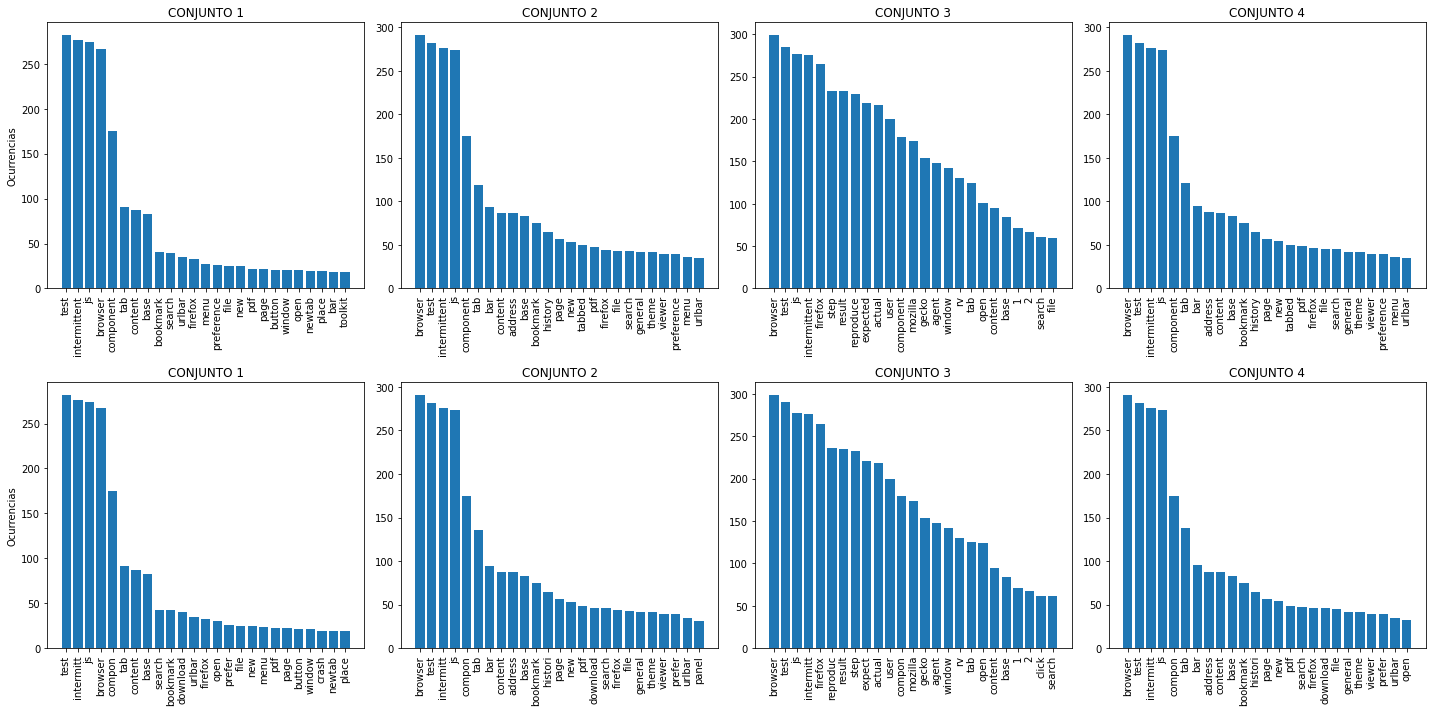

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))

# fig.set_title("Tokens compartidos entre Maestro y Duplicado más comunes")

axs[0,0].bar(range(len(rank_1L)), [x[1] for x in rank_1L], align='center')
axs[0,0].set_xticks(range(len(rank_1L)), [x[0] for x in rank_1L], rotation=90)
axs[0,0].set_ylabel('Ocurrencias')
axs[0,0].set_title('CONJUNTO 1')

axs[1,0].bar(range(len(rank_1S)), [x[1] for x in rank_1S], align='center')
axs[1,0].set_xticks(range(len(rank_1S)), [x[0] for x in rank_1S], rotation=90)
axs[1,0].set_ylabel('Ocurrencias')
axs[1,0].set_title('CONJUNTO 1')

axs[0,1].bar(range(len(rank_2L)), [x[1] for x in rank_2L], align='center')
axs[0,1].set_xticks(range(len(rank_2L)), [x[0] for x in rank_2L], rotation=90)
axs[0,1].set_title('CONJUNTO 2')

axs[1,1].bar(range(len(rank_2S)), [x[1] for x in rank_2S], align='center')
axs[1,1].set_xticks(range(len(rank_2S)), [x[0] for x in rank_2S], rotation=90)
axs[1,1].set_title('CONJUNTO 2')

axs[0,2].bar(range(len(rank_3L)), [x[1] for x in rank_3L], align='center')
axs[0,2].set_xticks(range(len(rank_3L)), [x[0] for x in rank_3L], rotation=90)
axs[0,2].set_title('CONJUNTO 3')

axs[1,2].bar(range(len(rank_3S)), [x[1] for x in rank_3S], align='center')
axs[1,2].set_xticks(range(len(rank_3S)), [x[0] for x in rank_3S], rotation=90)
axs[1,2].set_title('CONJUNTO 3')

axs[0,3].bar(range(len(rank_4L)), [x[1] for x in rank_4L], align='center')
axs[0,3].set_xticks(range(len(rank_4L)), [x[0] for x in rank_4L], rotation=90)
axs[0,3].set_title('CONJUNTO 4')

axs[1,3].bar(range(len(rank_4S)), [x[1] for x in rank_4S], align='center')
axs[1,3].set_xticks(range(len(rank_4S)), [x[0] for x in rank_4S], rotation=90)
axs[1,3].set_title('CONJUNTO 4')

fig.tight_layout()
plt.show()

# Añadir tokenes a dataframes

In [29]:
df_report_pairs['tokens1ML'] = df_report_pairs['text1M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens2ML'] = df_report_pairs['text2M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens3ML'] = df_report_pairs['text3M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens4ML'] = df_report_pairs['text4M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens1MS'] = df_report_pairs['text1M'].apply(preprocess_with_stemmer)
df_report_pairs['tokens2MS'] = df_report_pairs['text2M'].apply(preprocess_with_stemmer)
df_report_pairs['tokens3MS'] = df_report_pairs['text3M'].apply(preprocess_with_stemmer)
df_report_pairs['tokens4MS'] = df_report_pairs['text4M'].apply(preprocess_with_stemmer)

df_report_pairs['tokens1DL'] = df_report_pairs['text1D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens2DL'] = df_report_pairs['text2D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens3DL'] = df_report_pairs['text3D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens4DL'] = df_report_pairs['text4D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens1DS'] = df_report_pairs['text1D'].apply(preprocess_with_stemmer)
df_report_pairs['tokens2DS'] = df_report_pairs['text2D'].apply(preprocess_with_stemmer)
df_report_pairs['tokens3DS'] = df_report_pairs['text3D'].apply(preprocess_with_stemmer)
df_report_pairs['tokens4DS'] = df_report_pairs['text4D'].apply(preprocess_with_stemmer)

# Persistir

In [30]:
import os

if not os.path.exists('data'):
    os.makedirs('data')

df_reports.to_pickle('data/preprocessed_reports.pkl')
df_report_pairs[[
    'type', 'id_M', 'id_D', 'statusM', 'statusD',  'componentM', 'componentD',
    'summaryM', 'summaryD', 'commentsM',  'commentsD',
    'text1M', 'text1D', 'text2M', 'text2D', 'text3M', 'text3D', 'text4M', 'text4D',
    'tokens1ML', 'tokens2ML', 'tokens3ML', 'tokens4ML', 'tokens1DL', 'tokens2DL', 'tokens3DL', 'tokens4DL',
    'tokens1MS', 'tokens2MS', 'tokens3MS', 'tokens4MS', 'tokens1DS', 'tokens2DS', 'tokens3DS', 'tokens4DS'
]].to_pickle('data/preprocessed_report_pairs.pkl')